In [3]:
# ===============================
# Colab Environment Setup
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.impute import SimpleImputer # Added this line

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42
plt.style.use("default")

In [4]:
%store -r df
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
# ===============================
# Feature & Target Split
# ===============================
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"].map({"Y": 1, "N": 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (491, 12)
Test size: (123, 12)


In [7]:
# ===============================
# Preprocessing Pipeline
# ===============================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

/var/folders/pz/d5lbtr0x03g0qvwwc1jyg4wc0000gn/T/ipykernel_5545/381534639.py:5: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = X.select_dtypes(include=["object"]).columns


In [8]:
# ===============================
# Logistic Regression (Baseline)
# ===============================
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.81      0.66      0.72        38
           1       0.86      0.93      0.89        85

    accuracy                           0.85       123
   macro avg       0.83      0.79      0.81       123
weighted avg       0.84      0.85      0.84       123

ROC-AUC: 0.8557275541795665


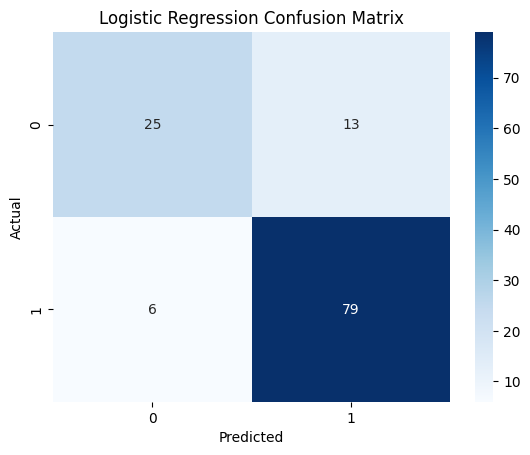

In [9]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [10]:
# ===============================
# Random Forest (Colab-safe)
# ===============================
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay

# If you already ran the preprocessing cell but it failed due to missing import,
# re-run the preprocessing cell after this import.

rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,        # Colab-safe (fast enough)
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced", # imbalance method #1 (again, for fair comparison)
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest Results ===")
print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_prob))

=== Random Forest Results ===
              precision    recall  f1-score   support

           0       0.92      0.58      0.71        38
           1       0.84      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.88      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123

ROC-AUC: 0.7899380804953561


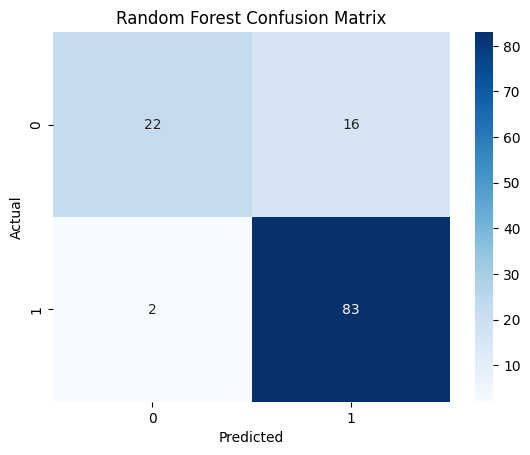

In [11]:
# ===============================
# Random Forest Confusion Matrix
# ===============================
cm_rf = confusion_matrix(y_test, rf_pred)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

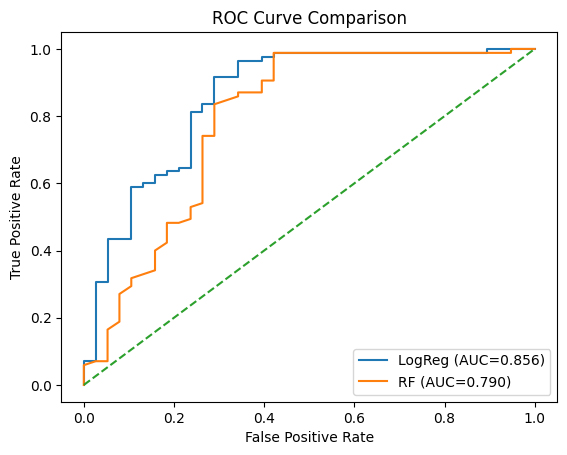

In [12]:
# ===============================
# ROC Curve: Logistic Regression vs Random Forest
# (Run this only if you already computed y_prob for log_reg earlier)
# ===============================
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc_score(y_test, y_prob):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_auc_score(y_test, rf_prob):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [13]:
# ===============================
# SMOTE Pipelines (Imbalance Method #2)
# Colab-safe: SMOTE applied ONLY on training folds
# ===============================
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

smote = SMOTE(random_state=RANDOM_STATE)

# ---- Logistic Regression + SMOTE ----
logreg_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", smote),
    ("model", LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

logreg_smote.fit(X_train, y_train)
lr_smote_pred = logreg_smote.predict(X_test)
lr_smote_prob = logreg_smote.predict_proba(X_test)[:, 1]

print("=== Logistic Regression + SMOTE ===")
print(classification_report(y_test, lr_smote_pred))
print("ROC-AUC:", roc_auc_score(y_test, lr_smote_prob))

=== Logistic Regression + SMOTE ===
              precision    recall  f1-score   support

           0       0.89      0.66      0.76        38
           1       0.86      0.96      0.91        85

    accuracy                           0.87       123
   macro avg       0.88      0.81      0.83       123
weighted avg       0.87      0.87      0.86       123

ROC-AUC: 0.8687306501547988


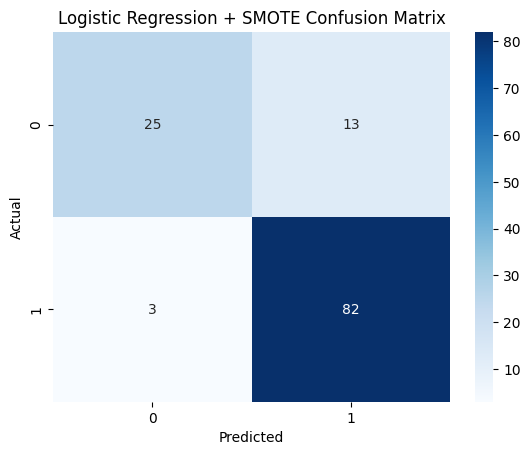

In [14]:
# ===============================
# Confusion Matrix: Logistic Regression + SMOTE
# ===============================
cm_lr_smote = confusion_matrix(y_test, lr_smote_pred)

sns.heatmap(cm_lr_smote, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression + SMOTE Confusion Matrix")
plt.show()

In [15]:
# ---- Random Forest + SMOTE ----
rf_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", smote),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_smote.fit(X_train, y_train)
rf_smote_pred = rf_smote.predict(X_test)
rf_smote_prob = rf_smote.predict_proba(X_test)[:, 1]

print("=== Random Forest + SMOTE ===")
print(classification_report(y_test, rf_smote_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_smote_prob))

=== Random Forest + SMOTE ===
              precision    recall  f1-score   support

           0       0.92      0.58      0.71        38
           1       0.84      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.88      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123

ROC-AUC: 0.8


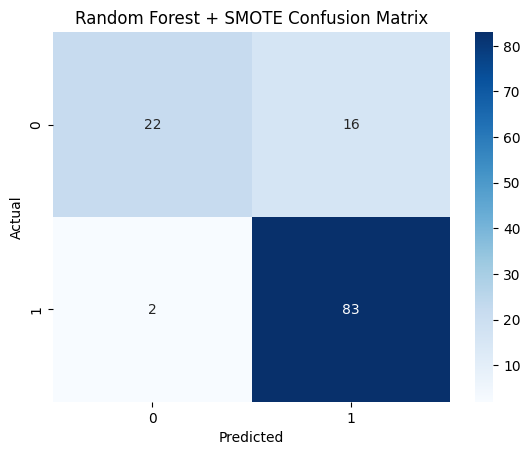

In [16]:
# ===============================
# Confusion Matrix: Random Forest + SMOTE
# ===============================
cm_rf_smote = confusion_matrix(y_test, rf_smote_pred)

sns.heatmap(cm_rf_smote, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest + SMOTE Confusion Matrix")
plt.show()

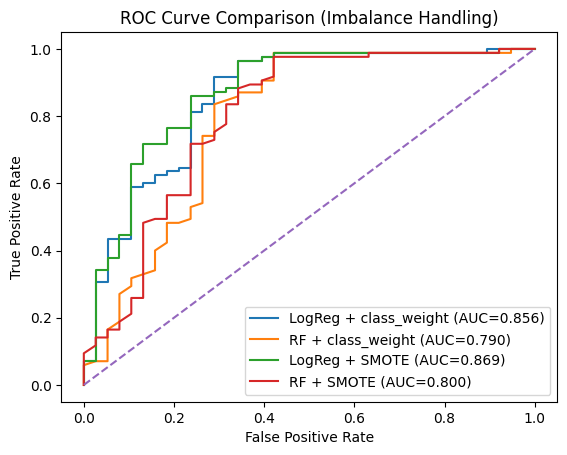

In [17]:
# ===============================
# ROC Curve Comparison (All 4)
# Requires: y_prob (log_reg), rf_prob (rf), lr_smote_prob, rf_smote_prob
# ===============================
curves = {
    "LogReg + class_weight": y_prob,
    "RF + class_weight": rf_prob,
    "LogReg + SMOTE": lr_smote_prob,
    "RF + SMOTE": rf_smote_prob
}

plt.figure()
for name, probs in curves.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Imbalance Handling)")
plt.legend()
plt.show()

In [18]:
# ===============================
# GridSearchCV: Logistic Regression + SMOTE
# ===============================
from sklearn.model_selection import GridSearchCV

logreg_smote_gs = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("model", LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"],
    "model__solver": ["liblinear"]
}


In [20]:
grid_search = GridSearchCV(
    estimator=logreg_smote_gs,
    param_grid=param_grid,
    scoring="f1",          # justified due to class imbalance
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV F1 Score:", grid_search.best_score_)

Best Parameters: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best CV F1 Score: 0.8673838291448431


/Users/brendanz/Documents/school/mini-project-2/mini-project-2-group10/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/brendanz/Documents/school/mini-project-2/mini-project-2-group10/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/brendanz/Documents/school/mini-project-2/mini-project-2-group10/.conda/

In [21]:
best_model = grid_search.best_estimator_

gs_pred = best_model.predict(X_test)
gs_prob = best_model.predict_proba(X_test)[:, 1]

print("=== Tuned Logistic Regression + SMOTE ===")
print(classification_report(y_test, gs_pred))
print("ROC-AUC:", roc_auc_score(y_test, gs_prob))

=== Tuned Logistic Regression + SMOTE ===
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123

ROC-AUC: 0.8733746130030959


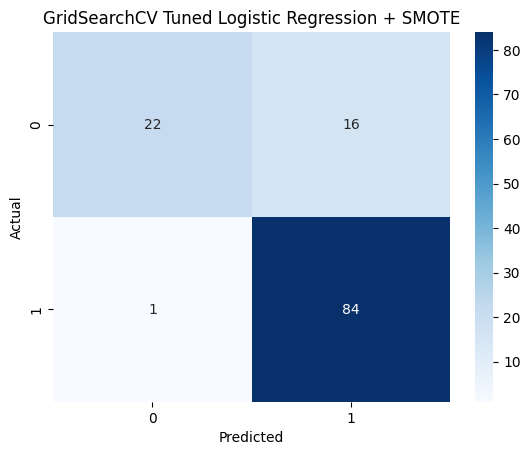

In [22]:
cm_gs = confusion_matrix(y_test, gs_pred)

sns.heatmap(cm_gs, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GridSearchCV Tuned Logistic Regression + SMOTE")
plt.show()

In [ ]:
fpr_base, tpr_base, _ = roc_curve(y_test, lr_smote_prob)
fpr_gs, tpr_gs, _ = roc_curve(y_test, gs_prob)

plt.figure()
plt.plot(fpr_base, tpr_base, label=f"LR + SMOTE (AUC={roc_auc_score(y_test, lr_smote_prob):.3f})")
plt.plot(fpr_gs, tpr_gs, label=f"Tuned LR + SMOTE (AUC={roc_auc_score(y_test, gs_prob):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Effect of Hyperparameter Tuning")
plt.legend()
plt.show()


In [23]:
# ===============================
# Final Results Comparison Table
# Requires these variables to exist from earlier cells:
# 1) y_pred, y_prob               -> Logistic Regression + class_weight
# 2) rf_pred, rf_prob             -> Random Forest + class_weight
# 3) lr_smote_pred, lr_smote_prob -> Logistic Regression + SMOTE
# 4) rf_smote_pred, rf_smote_prob -> Random Forest + SMOTE
# 5) gs_pred, gs_prob             -> Tuned Logistic Regression + SMOTE (GridSearchCV best)
# ===============================
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def make_row(name, y_true, y_pred, y_prob):
    return {
        "Model": name,
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }

rows = []
rows.append(make_row("LogReg (class_weight=balanced)", y_test, y_pred, y_prob))
rows.append(make_row("RandomForest (class_weight=balanced)", y_test, rf_pred, rf_prob))
rows.append(make_row("LogReg + SMOTE", y_test, lr_smote_pred, lr_smote_prob))
rows.append(make_row("RandomForest + SMOTE", y_test, rf_smote_pred, rf_smote_prob))
rows.append(make_row("Tuned LogReg + SMOTE (GridSearchCV)", y_test, gs_pred, gs_prob))

results_df = pd.DataFrame(rows)

# Pretty display
results_df_sorted = results_df.sort_values(by=["F1", "ROC-AUC"], ascending=False).reset_index(drop=True)
results_df_sorted

,Model,Precision,Recall,F1,ROC-AUC
0,LogReg + SMOTE,0.863158,0.964706,0.911111,0.868731
1,Tuned LogReg + SMOTE (GridSearchCV),0.840000,0.988235,0.908108,0.873375
2,RandomForest + SMOTE,0.838384,0.976471,0.902174,0.800000
3,RandomForest (class_weight=balanced),0.838384,0.976471,0.902174,0.789938
4,LogReg (class_weight=balanced),0.858696,0.929412,0.892655,0.855728


In [24]:
# ===============================
# Declare Best Model (based on F1, tie-breaker ROC-AUC)
# ===============================
best_row = results_df_sorted.iloc[0]
best_model_name = best_row["Model"]

print("Best model (by F1, tie-breaker ROC-AUC):")
print(best_model_name)
print(best_row)


Best model (by F1, tie-breaker ROC-AUC):
LogReg + SMOTE
Model        LogReg + SMOTE
Precision          0.863158
Recall             0.964706
F1                 0.911111
ROC-AUC            0.868731
Name: 0, dtype: object


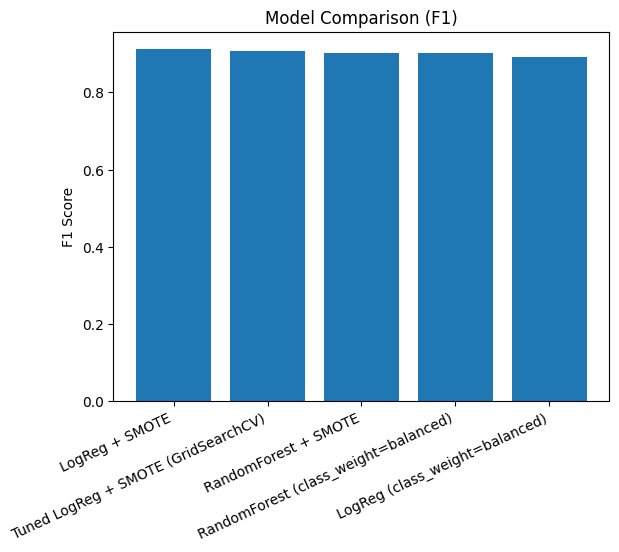

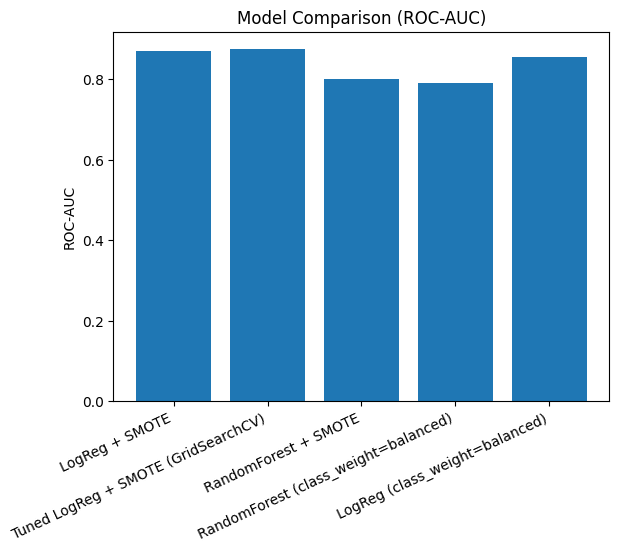

In [25]:
# ===============================
# OPTIONAL: Simple bar chart for report/README
# ===============================
plt.figure()
plt.bar(results_df_sorted["Model"], results_df_sorted["F1"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("F1 Score")
plt.title("Model Comparison (F1)")
plt.show()

plt.figure()
plt.bar(results_df_sorted["Model"], results_df_sorted["ROC-AUC"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("ROC-AUC")
plt.title("Model Comparison (ROC-AUC)")
plt.show()

In [26]:
# Add missingness indicators for any column with missing values
missing_cols = [c for c in X.columns if X[c].isna().any()]
for c in missing_cols:
    X[f"{c}_missing"] = X[c].isna().astype(int)

In [27]:
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

# Preprocessor for SMOTENC: numeric scaled, categorical ordinal-encoded
numeric_transformer_sm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer_sm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor_sm = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_sm, numeric_features),
        ("cat", categorical_transformer_sm, categorical_features),
    ]
)

# categorical indices after ColumnTransformer output: numeric first, then categorical
n_num = len(numeric_features)
n_cat = len(categorical_features)
cat_indices = list(range(n_num, n_num + n_cat))

smotenc = SMOTENC(categorical_features=cat_indices, random_state=RANDOM_STATE)

logreg_smotenc = ImbPipeline(steps=[
    ("preprocessor", preprocessor_sm),
    ("smotenc", smotenc),
    ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

In [28]:
gs = GridSearchCV(
    logreg_smotenc,
    param_grid={"model__C": [0.01, 0.1, 1.0]},
    scoring="f1",
    cv=3,
    n_jobs=1
)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_

In [29]:
def threshold_tune(y_true, y_prob, cost_fp=5.0, cost_fn=1.0):
    thresholds = np.linspace(0.05, 0.95, 91)
    best = None
    for t in thresholds:
        y_hat = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        expected_cost = cost_fp * fp + cost_fn * fn
        if best is None or expected_cost < best["ExpectedCost"]:
            best = {
                "Threshold": float(t),
                "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp),
                "ExpectedCost": float(expected_cost),
                "Precision": float(precision_score(y_true, y_hat, zero_division=0)),
                "Recall": float(recall_score(y_true, y_hat, zero_division=0)),
                "F1": float(f1_score(y_true, y_hat, zero_division=0)),
            }
    return best

prob = best_model.predict_proba(X_test)[:, 1]
best_thr = threshold_tune(y_test.values, prob, cost_fp=5.0, cost_fn=1.0)
best_thr

{'Threshold': 0.49999999999999994,
 'TN': 29,
 'FP': 9,
 'FN': 19,
 'TP': 66,
 'ExpectedCost': 64.0,
 'Precision': 0.88,
 'Recall': 0.7764705882352941,
 'F1': 0.825}